In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sma_strategy.data import fetch_data
from sma_strategy.indicators import sma_crossover_rsi_signal
from sma_strategy.backtest import backtest
from sma_strategy.plots import (
    plot_equity_vs_buyhold,
    plot_drawdown,
    plot_holding_periods,
    plot_top_trades,
    plot_cumulative_profit_per_trade,
    plot_rolling_sharpe,
)


In [22]:
SYMBOL = "AAPL"
START_DATE = "2010-01-01"
SMA_SHORT = 50
SMA_LONG = 200
CACHE_FILE = f"{SYMBOL}_daily_yf.csv"

In [23]:
df = fetch_data(symbol=SYMBOL, start=START_DATE, cache_file=CACHE_FILE)

df["Signal"] = sma_crossover_rsi_signal(
    df["adjusted_close"], short=50, long=200, rsi_period=14, rsi_low=30, rsi_high=70
)
df = backtest(df)

Loading cached data from AAPL_daily_yf.csv


## Cumulative Return: SMA 50×200 Strategy vs. Buy & Hold

This line plot shows the growth of $1 invested in either your SMA-cross strategy (Equity curve) or a simple buy-and-hold of AAPL over the same period.

- **Outperformance periods**: where the strategy curve sits above buy & hold.
- **Underperformance periods**: where it falls below.
- **Steeper slopes** correspond to periods of strong net gain; flat or negative slopes indicate little or no growth (or drawdown).


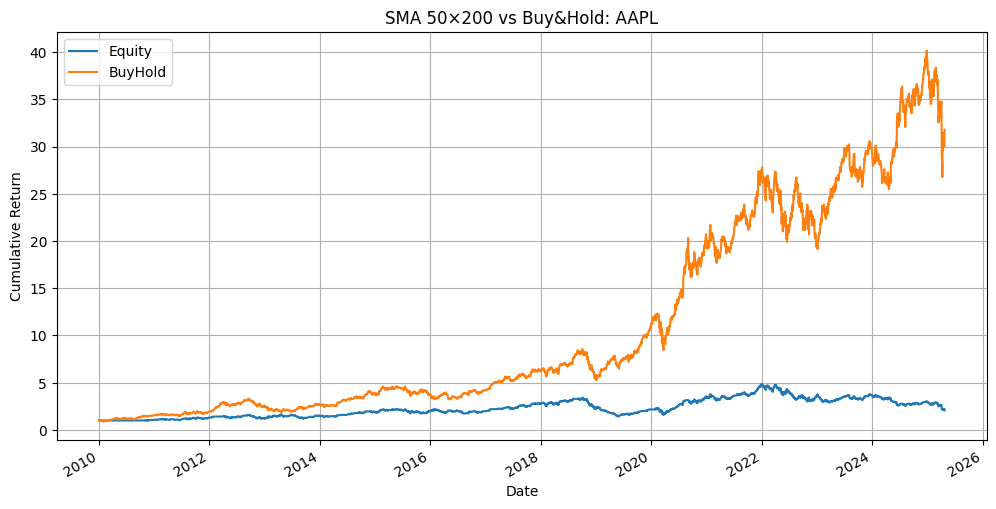

In [24]:
plot_equity_vs_buyhold(df, short=SMA_SHORT, long=SMA_LONG, symbol=SYMBOL)

## Drawdown Over Time

This filled‐area chart plots, at each date, how far the strategy equity is below its historical peak (drawdown = Equity/Peak – 1).

- **Peaks (drawdown = 0)** mark all-time highs.
- **Troughs** show the worst percentage drops from peak—key measure of risk.
- **Duration of drawdowns** indicates how long the strategy stayed below its last high.


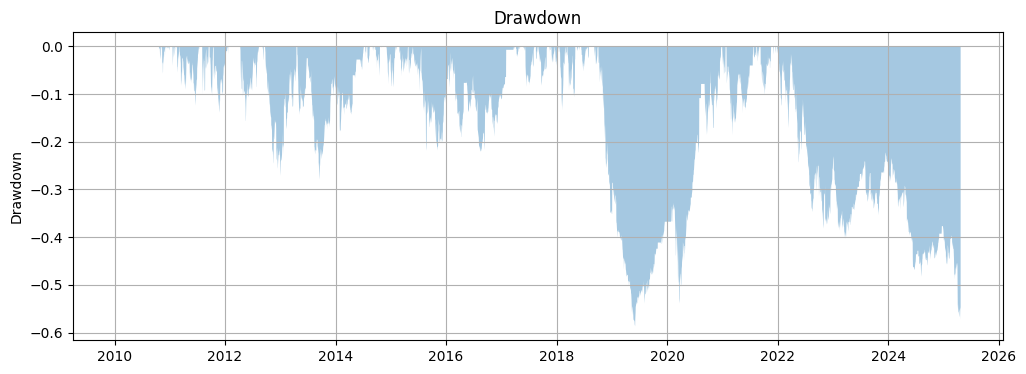

In [25]:
plot_drawdown(df)

## Distribution of Signal Holding Periods

This histogram shows the length (in bars) of every contiguous signal block—long (1), short (–1) or flat (0)—before the signal flips.

- **Flat blocks (Signal = 0)**
  - The tallest bars at “out-of-market” lengths reveal how long the strategy sits idle between trades.
  - Long flat stretches may indicate missed trends; very short flat bars mean you’re almost always in a position.
- **Long vs. Short block lengths**
  - If you split the histogram by `Signal` value, you’ll see whether long signals tend to persist longer (fat right-tail for 1) than shorts (fat tail for –1).
  - A cluster of short blocks (e.g. 1–5 bars) suggests choppy behavior—frequent flips that can rack up transaction costs.
- **Tail behavior**
  - A heavy tail (very long blocks) highlights trend-following periods where you stayed in one signal for hundreds of bars—good for capturing big moves, but also increases drawdown risk if the trend reverses.
- **Actionable insight**
  - Aim for a balance: reduce very short blocks (filter noise) while limiting excessively long blocks (cap drawdown).


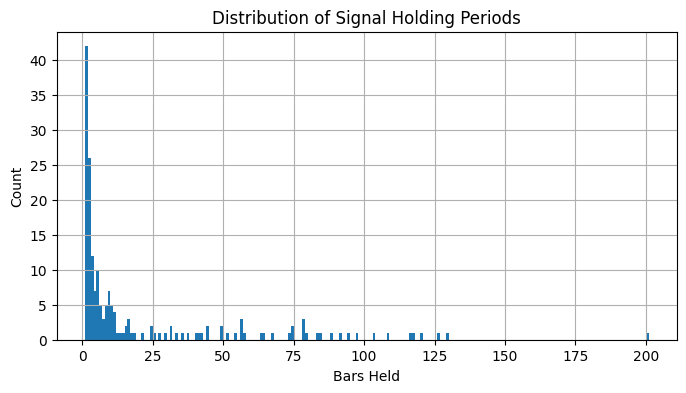

Number of signal changes: 193


In [26]:
plot_holding_periods(df)

## 30-Day Rolling Sharpe Ratio

A line plot of the strategy’s Sharpe ratio computed over a moving 30-day window:

- **Sharpe > 0** means returns exceeded volatility.
- **Sharpe < 0** indicates negative risk-adjusted performance.
- **Peaks and valleys** reveal when the strategy was most and least efficient.


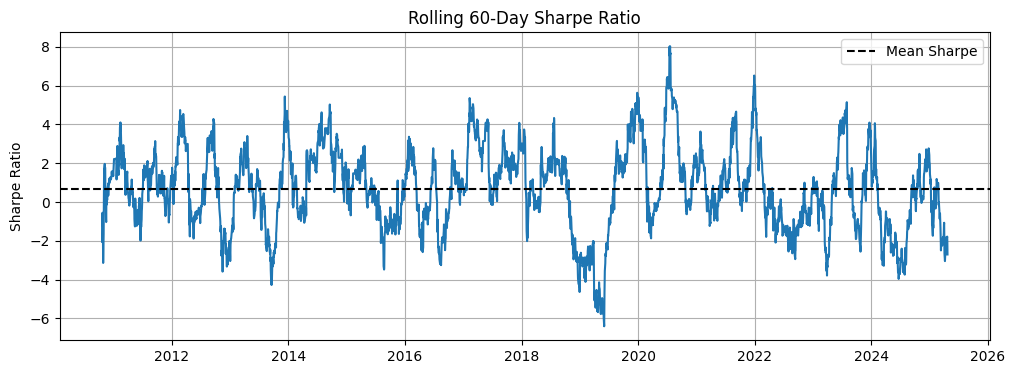

In [27]:
plot_rolling_sharpe(df)

## Top 10 Gains vs Top 10 Losses

Two back-to-back horizontal bar charts showing the ten largest one-day gains (green) and ten largest one-day losses (red).

- **Magnitude comparison** helps you see if your best days outweigh your worst days.
- **Frequency** of large losses vs. large gains can inform whether risk-management tweaks are needed.


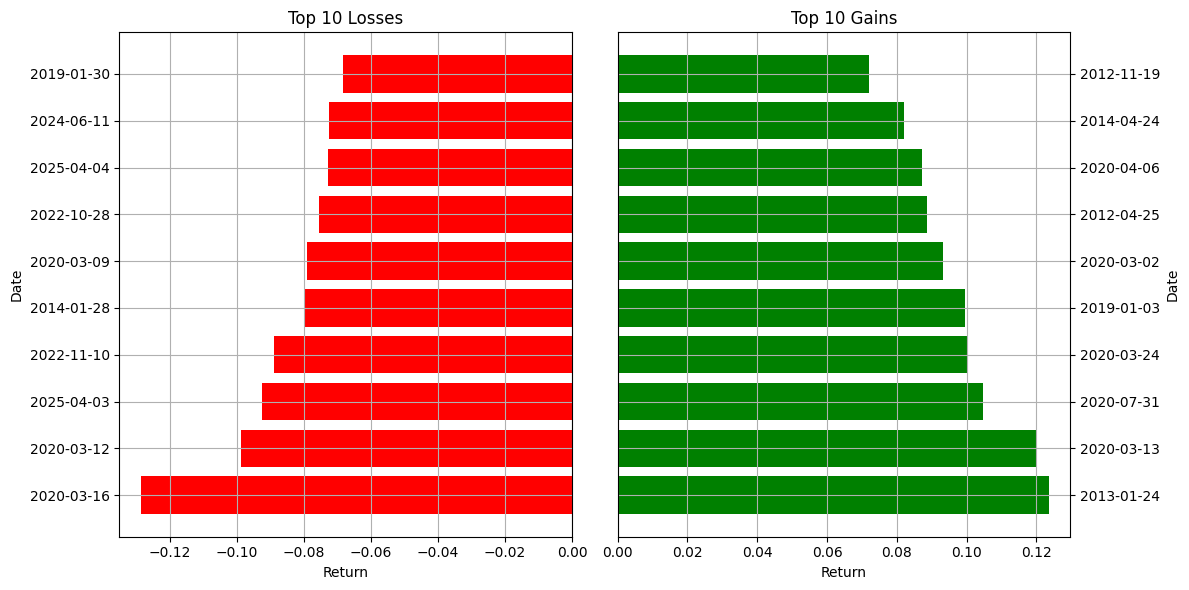

In [28]:
plot_top_trades(df, n=10)

## Cumulative Profit Per Trade

This line chart accumulates P&L only on the days you enter or exit a position (approximate profit per completed trade).

- **Steep upward jumps** correspond to highly profitable trades.
- **Flat segments** mean trades with near-zero net.
- **Downward steps** flag losing trades.
- **Net slope** over time shows whether your edge is positive.


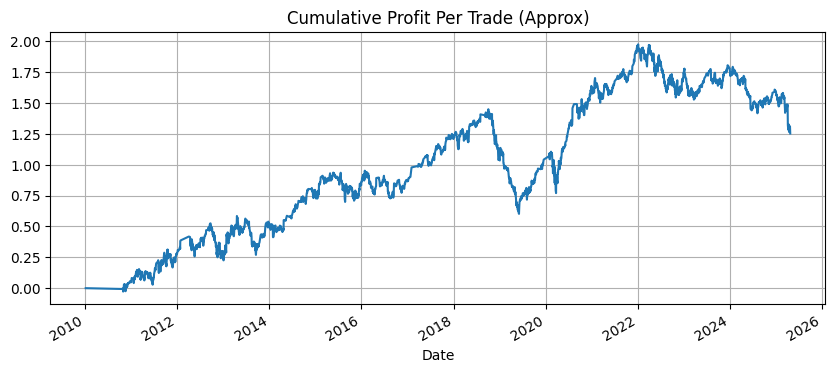

In [29]:
plot_cumulative_profit_per_trade(df)

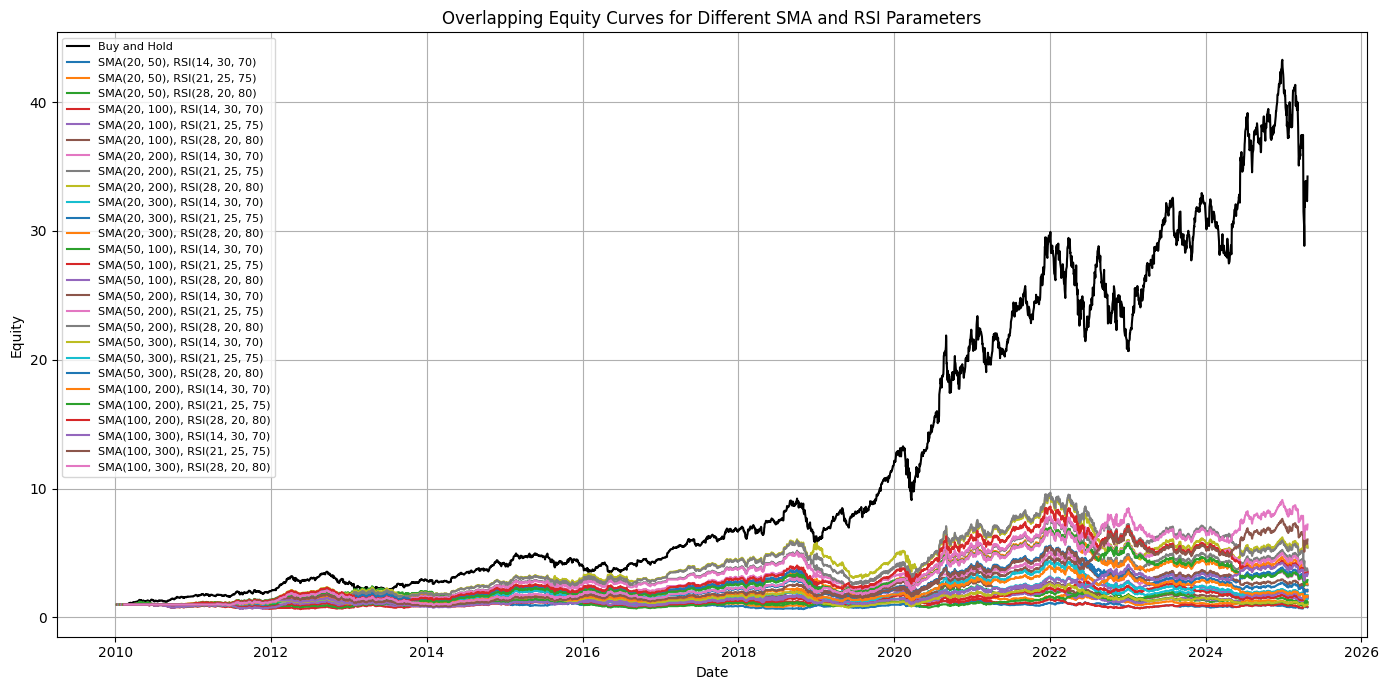

In [30]:
sma_short_windows = [20, 50, 100]
sma_long_windows = [50, 100, 200, 300]

rsi_params = [
    {"period": 14, "low": 30, "high": 70},
    {"period": 21, "low": 25, "high": 75},
    {"period": 28, "low": 20, "high": 80},
]
results = []
for sma_short in sma_short_windows:
    for sma_long in sma_long_windows:
        if sma_short >= sma_long:
            continue
        for rsi_param in rsi_params:
            df["Signal"] = sma_crossover_rsi_signal(
                df["adjusted_close"],
                short=sma_short,
                long=sma_long,
                rsi_period=rsi_param["period"],
                rsi_low=rsi_param["low"],
                rsi_high=rsi_param["high"],
            )
            df = backtest(df)
            results.append({"df": df, "params": (sma_short, sma_long, rsi_param)})

plt.figure(figsize=(14, 7))
plt.title("Overlapping Equity Curves for Different SMA and RSI Parameters")
plt.xlabel("Date")
plt.ylabel("Equity")

# Plot Buy and Hold for comparison
plt.plot(df.index, df["BuyHold"], label="Buy and Hold", color="black")

# Plotting overlapping equity for each result on a single graph
for i, result in enumerate(results):
    df = result["df"]
    sma_short, sma_long, rsi_param = result["params"]
    label = f"SMA({sma_short}, {sma_long}), RSI({rsi_param['period']}, {rsi_param['low']}, {rsi_param['high']})"
    plt.plot(df.index, df["Equity"], label=label)

# Adding legend and grid
plt.legend(loc="upper left", fontsize=8)
plt.grid()
plt.tight_layout()
plt.show()